# Predicting User Churn in Digital Music Services

Notebook to document data exploration and development of ML algorithm to identify at risk customers in digital music services.

### Data Definition

From Exploratory Data Analysis (EDA): 
#### Useful:
- *location*: location of user, seems to append each new state (location, state)
- *gender*: user gender (M/F/None)

- *page*: what page the user is on during event (pages)
- *level*: subscription level check uniqueness (free or paid)
- *auth*: authenication (logged in/out)
- *length*: time spent on page, max 50 mins on NextSong (if song paused??)

- *registration*: unknown (registration unixtime)
- *ts*: timestamp of event in ms (event unixtime)

- *userId*: unique (userId val)
- *sessionId*: unique sessionId per user?
- *itemInSession*: lcounter for the number of items in a single session (item listened to in session)


#### Not Useful:
- *firstName*: users first name (not important, remove)
- *lastName*: users lastname
- *artist*: song artist
- *song*: songname
- *userAgent*: device/browser (not important for us, remove)
- *method*: API PUT/GET http request (not important for us, remove)
- *status*: http status

# Apache Spark on IBM Watson Setup

### Imports

In [1]:
# imports
#import ibmos2spark

# pyspark sql
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import from_unixtime, udf, col, when, isnan, desc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col

# python
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

### setup

In [2]:
# # config
# # @hidden_cell
# credentials = {
#     'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
#     'service_id': 'iam-ServiceId-147e1161-7da9-41fe-ac00-c144730def00',
#     'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
#     'api_key': 'kAtvjdC8VIYYUmU3gDaOYIK2fCvP3nkjYYlDiNuu4gw6'
# }

# configuration_name = 'os_76774389dfa04fb5acbb1640b3e11704_configs'
# cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

In [2]:
# Build Spark session
spark = SparkSession.builder.appName("user_churn").getOrCreate()

# Read in data from IBM Cloud
# data_df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-fnqu5byx41gcai'))

data_df = spark.read.json("../data/01_raw/medium-sparkify-event-data.json")

# Data Wrangling

### Remove non-useful columns and drop missing values

In [3]:
def clean_df(data_df):
    """Remove non useful columns and drop missing values for user and session.
    """
    # lets remove some of the columns we don't think will be useful from data exploration
    cols_to_drop = ['firstName', 'lastName','artist', 'song', 'method', 'status', 'userAgent']
    user_log_df = data_df.drop(*cols_to_drop)
    # drop rows with missing info
    return user_log_df.dropna(how = "any", subset = ["userId", "sessionId"])
    
user_log_valid = clean_df(data_df)

### Convert UNIX timestamps to Datatime

In [4]:
def unix_to_datetime(user_log_valid):
    """ Convert unix timestamps to datetime
    """
    # event unix to datetime
    user_log_valid = user_log_valid.withColumn("timestampDatetime",
                                         from_unixtime(user_log_valid.ts/1000,
                                                       format='yyyy-MM-dd HH:mm:ss'))
    # registration unix to datetime
    user_log_valid = user_log_valid.withColumn("registrationDatetime",
                                         from_unixtime(user_log_valid.registration/1000,
                                                       format='yyyy-MM-dd HH:mm:ss'))
    return user_log_valid

user_log_valid = unix_to_datetime(user_log_valid)

### Creating US State Feature for Visualisation

In [5]:
# missing values cause issue with split
user_log_valid.filter((user_log_valid["location"].isNull())).count()

15700

In [6]:
def create_us_states(user_log_valid):
    """Create US states column from location
    """
    # we don't really want to drop these rows as the col isn't vital 
    # so replace missing values to allow split
    user_log_valid = user_log_valid.fillna({'location':''})
    # create state column
    loc_split = udf(lambda x: x.split(', ')[-1], StringType())
    # Sates seem to be appended, so take latest
    state_split = udf(lambda x: x.split('-')[-1], StringType())

    # apply udfs
    user_log_valid = user_log_valid.withColumn("usStateAbbr",
                                         when(user_log_valid.location.isNotNull(),
                                              loc_split(user_log_valid.location)).otherwise(''))
    user_log_valid = user_log_valid.withColumn("usStateAbbr",
                                         when(user_log_valid.usStateAbbr.isNotNull(),
                                              state_split(user_log_valid.usStateAbbr)).otherwise(''))
    return user_log_valid
    
user_log_valid = create_us_states(user_log_valid)

In [20]:
def hour_in_day(user_log_valid):

    # hour in the day of event
    get_hour = udf(lambda x:  int(datetime.datetime.fromtimestamp(x / 1000.0).hour), IntegerType()) 
    user_log_valid = user_log_valid.withColumn("hour", get_hour(user_log_valid.ts))
    return user_log_valid

user_log_valid = hour_in_day(user_log_valid)

In [9]:
user_log_valid.show(5)

+---------+------+-------------+---------+-----+--------------------+--------+-------------+---------+-------------+------+-------------------+--------------------+-----------+----+
|     auth|gender|itemInSession|   length|level|            location|    page| registration|sessionId|           ts|userId|  timestampDatetime|registrationDatetime|usStateAbbr|hour|
+---------+------+-------------+---------+-----+--------------------+--------+-------------+---------+-------------+------+-------------------+--------------------+-----------+----+
|Logged In|     M|           20|597.55057| free|  Corpus Christi, TX|NextSong|1532063507000|      292|1538352011000|   293|2018-10-01 01:00:11| 2018-07-20 06:11:47|         TX|   1|
|Logged In|     M|           74|380.21179| free|Houston-The Woodl...|NextSong|1538069638000|       97|1538352025000|    98|2018-10-01 01:00:25| 2018-09-27 18:33:58|         TX|   1|
|Logged In|     M|          184|202.37016| paid|Orlando-Kissimmee...|NextSong|153595345500

In [9]:
cols_to_drop = ['location']
user_log_valid = user_log_valid.drop(*cols_to_drop)

In [10]:
wrangled_data = user_log_valid.withColumnRenamed("auth", "authLevel").\
withColumnRenamed("length", "sessionLength_s").\
withColumnRenamed("level", "subLevel").\
withColumnRenamed("ts", "unixEventTS").\
withColumnRenamed("registration", "unixRegistrationTS")
wrangled_data.show()

+----------+------+-------------+---------------+--------+---------------+------------------+---------+-------------+------+-------------------+--------------------+-----------+
| authLevel|gender|itemInSession|sessionLength_s|subLevel|           page|unixRegistrationTS|sessionId|  unixEventTS|userId|  timestampDatetime|registrationDatetime|usStateAbbr|
+----------+------+-------------+---------------+--------+---------------+------------------+---------+-------------+------+-------------------+--------------------+-----------+
| Logged In|     M|           20|      597.55057|    free|       NextSong|     1532063507000|      292|1538352011000|   293|2018-10-01 01:00:11| 2018-07-20 06:11:47|         TX|
| Logged In|     M|           74|      380.21179|    free|       NextSong|     1538069638000|       97|1538352025000|    98|2018-10-01 01:00:25| 2018-09-27 18:33:58|         TX|
| Logged In|     M|          184|      202.37016|    paid|       NextSong|     1535953455000|      178|1538352

In [20]:
def replace_missing_gender(wrangled_data):
    """replace missing gender with 'unknown'.
    """
    return wrangled_data.fillna({'gender':'unknown'})

wrangled_data = replace_missing_gender(wrangled_data)

In [24]:
def check_data_validity(df):
    print(df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).head())

check_data_validity(wrangled_data)

Row(authLevel=0, gender=0, itemInSession=0, sessionLength_s=110828, subLevel=0, page=0, unixRegistrationTS=15700, sessionId=0, unixEventTS=0, userId=0, timestampDatetime=0, registrationDatetime=15700, usStateAbbr=0)


In [25]:
wrangled_data.write.parquet("../data/03_primary/medium-sparkify-event-data-wrangled.parquet", mode="overwrite")

In [27]:
nextsong_dist_df = user_log_valid.filter(user_log_valid['page']=='NextSong').groupBy('hour').count().orderBy('hour').toPandas()

In [28]:
cancellation_dist_df = user_log_valid.filter(user_log_valid['page']=='Cancellation Confirmation').groupBy('hour').count().orderBy('hour').toPandas()

In [29]:
nextsong_dist_df['nextsong_normalised'] = nextsong_dist_df['count']/nextsong_dist_df['count'].max()
cancellation_dist_df['cancellation_normalised'] = cancellation_dist_df['count']/cancellation_dist_df['count'].max()

In [37]:
usage_df = cancellation_dist_df.join(nextsong_dist_df, on='hour', lsuffix='l', rsuffix='r',)

In [39]:
usage_df.head()

,hourl,countl,cancellation_normalised,hourr,countr,nextsong_normalised
0,0,6,0.857143,0,17657,0.782530
1,1,5,0.714286,1,17425,0.772248
2,2,2,0.285714,2,16569,0.734311
3,3,4,0.571429,3,15862,0.702978
4,4,4,0.571429,4,15420,0.683389


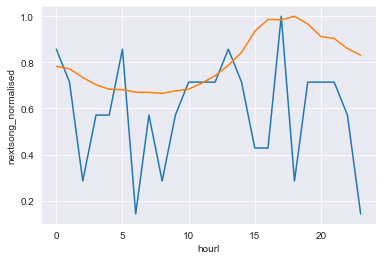

In [41]:
ax = sns.lineplot(x="hourl", y="cancellation_normalised", markers=True, data=usage_df)
ax = sns.lineplot(x="hourl", y="nextsong_normalised", markers=True, data=usage_df)

In [ ]:
usage_df = user_log_valid.filter((user_log_valid['page']=='Cancellation Confirmation') & (user_log_valid['subLevel']=='Paid')).groupBy('hour').count().orderBy('hour').toPandas()
